In [1]:
from __future__ import absolute_import, division, print_function

import dolfin as dl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from hippylib import *

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

In [2]:
ndim = 2
nx = 32
ny = 32
mesh = dl.UnitSquareMesh(nx, ny)
Vh2 = dl.FunctionSpace(mesh, 'Lagrange', 2)
Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vh = [Vh2, Vh1, Vh2]
print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(
    Vh[STATE].dim(), Vh[PARAMETER].dim(), Vh[ADJOINT].dim()) )

Number of dofs: STATE=4225, PARAMETER=1089, ADJOINT=4225


In [35]:
def eval_on_grid(u, n=10):
    x = np.linspace(0,1,n)
    y = np.linspace(0,1,n)
    X,Y = np.meshgrid(x,y)
    xx = X.flatten()
    yy = Y.flatten()
    return np.array([u(x,y) for x, y in zip(xx,yy)])

In [36]:
def f_expr(x,y):
    f = dl.interpolate(dl.Expression("std::exp(-pow(x[0]-{0},2)/0.1)*std::exp(-pow(x[1]-{1},2)/0.1)".format(x,y), degree=5), Vh2)
    return f

def generate_f(flocs, weights):
    f = weights[0]*f_expr(flocs[0][0], flocs[0][1])
    for floc, weight in zip(flocs[1:], weights[1:]):
        f += weight*f_expr(floc[0], floc[1])
    return f

def solve_system(f):
    def boundary(x, on_boundary):
        return on_boundary

    bc_state = dl.DirichletBC(Vh2, dl.Constant(0.0), boundary)
    u = dl.Function(Vh2)
    u_trial = dl.TrialFunction(Vh2)
    u_test  = dl.TestFunction(Vh2)
    omega = dl.Constant(0.5)
    mtrue = dl.interpolate(dl.Expression('std::log( 40. - 20.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5), Vh1)
    a = (-dl.inner(dl.grad(u_trial), dl.grad(u_test)) + omega*omega*dl.inner(dl.exp(2*mtrue)*u_trial, u_test)) * dl.dx
    L = -f * u_test * dl.dx
    A,b = dl.assemble_system(a, L, bc_state)
    dl.solve(A, u.vector(), b)
    return u

In [37]:
declist = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
flocs = np.array([[i,j] for i in declist for j in declist])

weights = np.random.normal(0,1,len(flocs))

### Demonstrate that the two ways of defining the expression are equivalent.

In [38]:
# f = generate_f(flocs,weights)

In [39]:
# u = solve_system(f)

In [40]:
# ug = eval_on_grid(u)

In [41]:
# plt.contourf(ug.reshape(50,50))
# plt.colorbar()

## Alternative Generation Method

In [42]:
ulist = [solve_system(generate_f([floc], [1])) for floc in flocs]

In [125]:
n = 40
U = np.array([eval_on_grid(u,n) for u in ulist]).T

In [126]:
u2 = U @ np.array(weights)

Note that the error is close to machine-$\epsilon$

In [123]:
# plt.contourf((ug-u2).reshape(50,50))
# plt.colorbar()


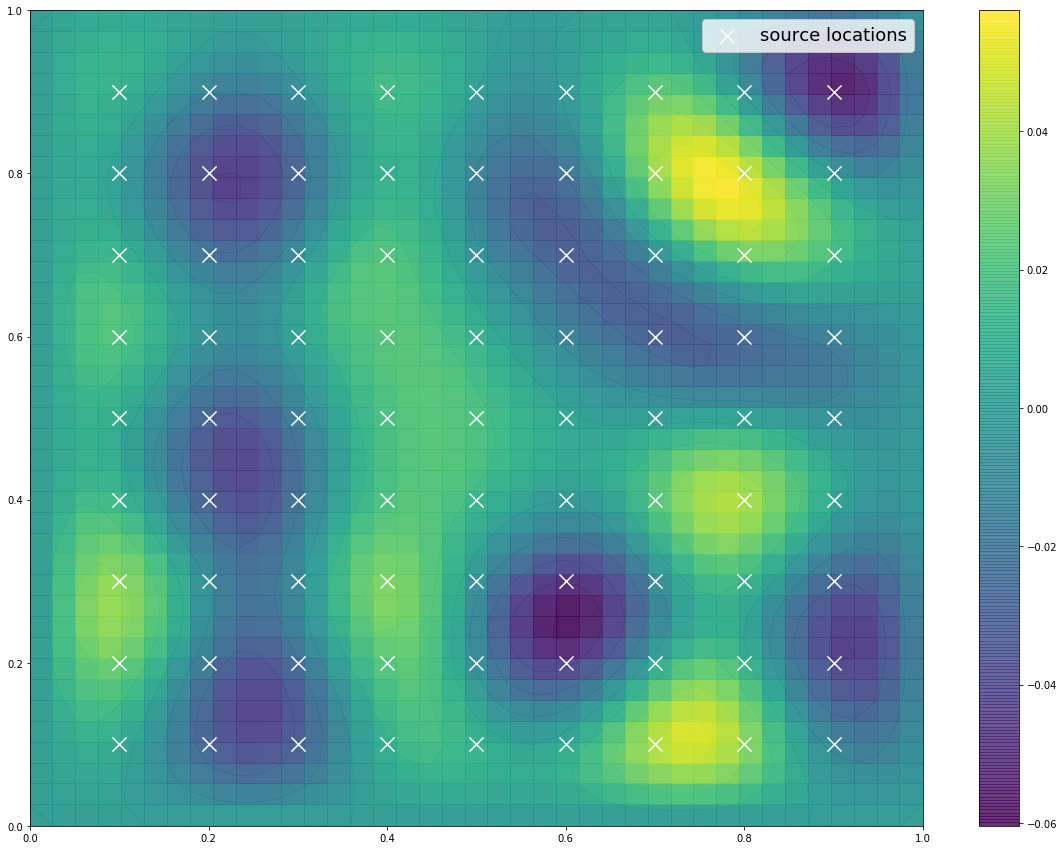

In [127]:
x = np.mgrid[0:1:40j, 0:1:40j]

# x = np.mgrid[0:1:60j, 0:1:60j]

# x = np.mgrid[0:1:80j, 0:1:80j]

plt.figure(figsize=(20,15))
plt.contourf(x[0,:],x[1,:],u2.reshape(n,n), alpha=0.5)
plt.pcolor(x[0,:],x[1,:],u2.reshape(n,n), alpha=0.8)
plt.colorbar()
plt.scatter(flocs[:,0], flocs[:,1], marker='x', c='white', s=200, label='source locations')
plt.legend(fontsize=18)
plt.show()

In [79]:
x

array([[[ 0.]],

       [[ 0.]]])

In [18]:
u2.shape

(2500,)

In [20]:
weights.shape

(81,)

In [22]:
flocs.shape

(81, 2)

In [28]:
len(ulist)

81

In [31]:
U.shape

(2500, 81)